In [3]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from edward.models import Normal

ed.set_seed(12)
sns.set()
%matplotlib inline

In [4]:
# Our model will be a two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()

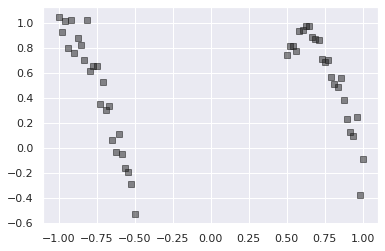

In [5]:
x_train = np.concatenate([np.linspace(0, 2, num=25),
                           np.linspace(6, 8, num=25)])
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = (x_train - 4.0) / 4.0
x_train = x_train.reshape((50,1))

plt.plot(x_train, y_train, 'ks', alpha=0.5)

In [6]:
# Build a Bayesian Neural Network with normal priors over weights
W_0 = Normal(loc=tf.zeros([1, 20]), scale=tf.ones([1, 20]))
W_1 = Normal(loc=tf.zeros([20, 1]), scale=tf.ones([20, 1]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# x = tf.placeholder(tf.float32, (50,1))
x = Normal(loc=0.5*tf.ones([50, 1]), scale=tf.ones([50, 1]))
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(50))

In [7]:
# Posterior approximators
qW_0 = Normal(loc=tf.Variable(tf.random_normal([1, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qx = Normal(loc=tf.Variable(tf.random_normal([50, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([50, 1]))))

In [8]:
# Sample neural networks from our variational model.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=500, dtype=np.float32)
nx = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(nx, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample())
     for _ in range(10)])


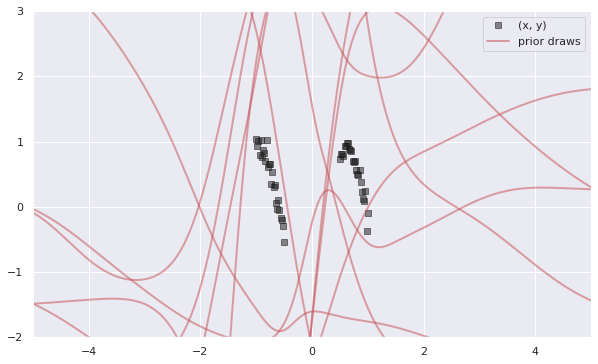

In [9]:
# Visualize prior draws.
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'prior draws')

In [10]:
print(x_train.shape, y_train.shape, outputs.shape)

(50, 1) (50,) (10, 500)


In [11]:
# Minimize the KL-divergence of our posterior approximators.
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1, x:qx},
                    data={x: x_train, y: y_train})
inference.run(n_iter=5000)

/home/jovyan/.local/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


5000/5000 [100%] ██████████████████████████████ Elapsed: 19s | Loss: 200.820


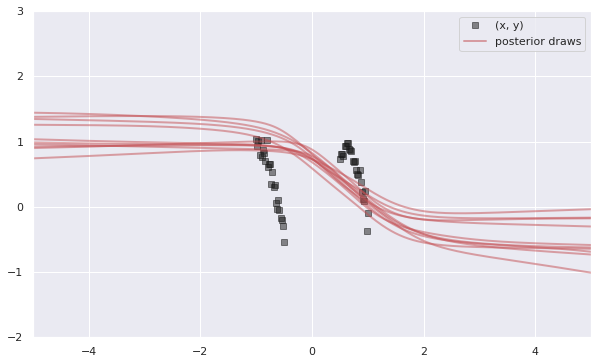

In [12]:
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')

Displaying posterior predictive samples.


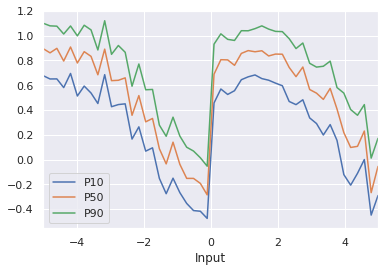

In [13]:
import pandas as pd
print("Displaying posterior predictive samples.")
n_posterior_samples = 100

qW_0_post = qW_0.sample(n_posterior_samples).eval()
qW_1_post = qW_1.sample(n_posterior_samples).eval()
qb_0_post = qb_0.sample(n_posterior_samples).eval()
qb_1_post = qb_1.sample(n_posterior_samples).eval()
qx_post = qx.sample(n_posterior_samples).eval()

#w_post = qw.sample(n_posterior_samples).eval()
#b_post = qb.sample(n_posterior_samples).eval()
#plt.scatter(X_train, y_train)

#inputs = np.linspace(-1, 10, num=400)
inputs = np.linspace(-5, 5, num=50, dtype=np.float32)
inputs = np.reshape(inputs, (50,1))
df = pd.DataFrame()
for ns in range(n_posterior_samples):
    #print("qx_post: ", type(qx_post[ns]), qx_post[ns].shape)
    #print("inputs:", type(inputs), inputs.shape)
    #h_post = tf.matmul(inputs, qW_0_post[ns]) + qb_0_post[ns]
    h_post = tf.matmul(qx_post[ns], qW_0_post[ns]) + qb_0_post[ns]
    h_post = tf.tanh(h_post)
    h_post = tf.matmul(h_post, qW_1_post[ns]) + qb_1_post[ns]
    output = tf.reshape(h_post, [-1])
    #print("output: ", type(output), output.shape)
    #output = inputs * w_post[ns] + b_post[ns]
    df.loc[:, ns] = output.eval()
    #plt.plot(inputs, output)

df['P50'] = df.quantile(q=0.5, axis=1, numeric_only=True, interpolation='linear')
df['P10'] = df.quantile(q=0.1, axis=1, numeric_only=True, interpolation='linear')
df['P90'] = df.quantile(q=0.9, axis=1, numeric_only=True, interpolation='linear')
df['Input'] = inputs

df.plot(x='Input', y=['P10','P50','P90'])

plt.show()